# This notebook performs a binary classifier analysis by training an XGBoost model with the distance data. A smaller training dataset was used to make this model so that a larger testing dataset could be analysed and compared with the RBD-ID data
Note that sci-learn version >= 1.0 is required.

In [1]:
import os
import random
import math
import yaml
import glob
import sys
import pandas as pd
import numpy as np
import shutil
import matplotlib
import matplotlib.pyplot as plt
import optuna
import joblib
import seaborn as sns
import xgboost as xgb
from itertools import combinations
from pyRBDome.Functions.RBDomeAnalysisCode import *
from pyRBDome.Functions.RBDomeSQL import *
from pyRBDome.Classes.PDBAnalyser import * 
from pathlib import Path
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import *
from sklearn.utils import shuffle, resample
from sklearn.utils.class_weight import compute_class_weight

matplotlib.rcParams['font.family'] = 'Arial'

### Loading settings:

In [2]:
settings_file = open('settings.yaml','r')
settings = yaml.load(settings_file,Loader=yaml.FullLoader)

In [3]:
### Parameters:
out_dir = os.path.abspath(settings[0]['general']['out_dir'])
data = os.path.abspath(settings[0]['general']['datafile'])
pdb_dir = os.path.abspath(settings[0]['general']['pdb_dir'])
proteome = os.path.abspath(settings[0]['general']['proteome'])

### Database parameters
database_name = settings[4]['database']['database_name']
database_table = 'All_combined_results'

In [4]:
database_name

'pyrbdome_full.db'

In [5]:
database_table

'All_combined_results'

In [6]:
def normalizeValues(values):
    """ Normalises the data to values between 0 and 1. """
    
    valid_values = [float(val) for val in values if val]
    
    min_val = min(valid_values)
    max_val = max(valid_values)
    
    normalised_values = list()
    
    for val in values:
        if not val:
            normalised_values.append(None)
        else:
            normalised = (val - min_val) / (max_val - min_val)
            normalised_values.append(normalised)
    
    return normalised_values

In [7]:
def binariseData(values,mindistance=4.2):
    scores = []
    threshold = mindistance
    for value in values:
        if not value:
            scores.append(np.nan)
        elif value <= threshold:
            scores.append(1)
        else:
            scores.append(0)
    return scores

In [8]:
def assignScoresToDistances(values):
    """ Normalises distance data from pdb files to values between 0 and 1.
    Lower distance values will get a score closer to 1 and higher values a
    score closer to 0. """
    
    valid_values = list()
    
    for val in values:
        if val and not math.isinf(val):
            valid_values.append(val)

    max_val = max(valid_values)
    
    ### Creating a list of normalised values
    normalised_values = list()
    
    reversed_values = [max_val - i for i in valid_values]
    min_reversed = min(reversed_values)
    max_reversed = max(reversed_values)
    
    for value in values:
        if not value:
            normalised_values.append(np.nan)
        else:
            value = float(value)
            reversed_value = max_val - value
            score = (reversed_value - min_reversed)/(max_reversed -  min_reversed)
            #assert score != np.inf
            normalised_values.append(score)
            
    return normalised_values

### Getting the massive results table from the database:

In [9]:
all_results_table = loadTableFromSQLite(database_table,database_name,verbose=True)

Table 'All_combined_results' successfully loaded from database 'pyrbdome_full.db' 


### Removing proteins that in the crystal structures did not interact with RNA. This will help to improve the binary classification.

In [10]:
to_remove = list()
for uniprot_id in sorted(set(all_results_table.loc[:,'ID'])):
    if min(all_results_table.loc[all_results_table['ID'] == uniprot_id,'Distance_to_RNA']) > 4.2:
        to_remove.append(uniprot_id)

### Removing these from the table:

In [11]:
indices = all_results_table.loc[all_results_table['ID'].isin(to_remove)].index

In [12]:
all_results_table.drop(index=indices,inplace=True)

In [13]:
all_results_table = all_results_table.reset_index()

In [14]:
all_results_table.head()

index      ID         pdb_id  residue_number amino_acid  aaRNA  PST_PRNA  \
0      0  P23396  P23396_merged               1          M  53.46      0.00   
1      1  P23396  P23396_merged               2          A  47.02      0.02   
2      2  P23396  P23396_merged               3          V  37.38      0.01   
3      3  P23396  P23396_merged               4          Q  57.55      0.16   
4      4  P23396  P23396_merged               5          I  42.46      0.05   

  BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  Distance_to_RNA  \
0    0.0            14.07          0.25         0.16    0.0             8.07   
1    0.0            14.31          0.24         0.17    0.0             4.78   
2    0.0             9.73          0.68         0.17    0.0             2.88   
3    0.0            11.99          0.68         0.17    0.0             2.62   
4    0.0             8.22          0.13         0.16    0.0             2.85   

   PLIP  Distance_to_PLIP  
0   NaN               NaN  
1   NaN               NaN  
2   NaN               NaN  
3   NaN               NaN  
4   NaN               NaN

### For how many proteins do we have structural data?

In [15]:
print(len(set(all_results_table['ID'])))

347


### Now converting the data containing prediciton results to numerical values:

In [16]:
numerical_columns = ['aaRNA','PST_PRNA','BindUP','FTMap_distances','RNABindRPlus',
                     'DisoRDPbind','HydRa','Distance_to_RNA','PLIP']

In [17]:
all_results_table = convertToNumeric(all_results_table,numerical_columns)

### Now normalising the data to values between 0 and 1:

### aaRNA, BindUP and PLIP columns need to have values between 0-1: 
Some amino acids in the plip data have very high numbers. These are residues that interact with RNA in multiple crystal structures, often through multiple types of interactions.

In [18]:
all_results_table.loc[:,'aaRNA'] = normalizeValues(all_results_table.loc[:,'aaRNA'].values)

In [19]:
all_results_table.loc[:,'BindUP'][all_results_table['BindUP'] > 0] = 1.0

### In the case of the FTMap data, the lower the value the better. 
We asume that anything that is 4.2A away from a ligand has the potential to form hydrogen bonds.
So the values in these columns will be normalised to 0 and 1, whith the shortest distances having the higher score.

In [20]:
all_results_table.loc[:,'FTMap_distances'] = assignScoresToDistances(all_results_table.loc[:,'FTMap_distances'].values)

In [21]:
all_results_table.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
0      0  P23396  P23396_merged               1          M  0.536385   
1      1  P23396  P23396_merged               2          A  0.471745   
2      2  P23396  P23396_merged               3          V  0.374987   
3      3  P23396  P23396_merged               4          Q  0.577437   
4      4  P23396  P23396_merged               5          I  0.425976   

   PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
0      0.00    0.0         0.906480          0.25         0.16    0.0   
1      0.02    0.0         0.904827          0.24         0.17    0.0   
2      0.01    0.0         0.936368          0.68         0.17    0.0   
3      0.16    0.0         0.920804          0.68         0.17    0.0   
4      0.05    0.0         0.946767          0.13         0.16    0.0   

   Distance_to_RNA  PLIP  Distance_to_PLIP  
0             8.07   NaN               NaN  
1             4.78   NaN               NaN  
2             2.88   NaN               NaN  
3             2.62   NaN               NaN  
4             2.85   NaN               NaN

### making the Distance_to_RNA values binary. Anything equal to or below 4.2Å away from RNA will get a score of 1. The rest will be 0.

In [22]:
all_results_table['Distance_to_RNA'] = binariseData(all_results_table.loc[:,'Distance_to_RNA'])

### Do the same for the PLIP data:

In [23]:
all_results_table['PLIP'][all_results_table['PLIP'] > 0] = 1

In [24]:
all_results_table.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
0      0  P23396  P23396_merged               1          M  0.536385   
1      1  P23396  P23396_merged               2          A  0.471745   
2      2  P23396  P23396_merged               3          V  0.374987   
3      3  P23396  P23396_merged               4          Q  0.577437   
4      4  P23396  P23396_merged               5          I  0.425976   

   PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
0      0.00    0.0         0.906480          0.25         0.16    0.0   
1      0.02    0.0         0.904827          0.24         0.17    0.0   
2      0.01    0.0         0.936368          0.68         0.17    0.0   
3      0.16    0.0         0.920804          0.68         0.17    0.0   
4      0.05    0.0         0.946767          0.13         0.16    0.0   

   Distance_to_RNA  PLIP  Distance_to_PLIP  
0                0   NaN               NaN  
1                0   NaN               NaN  
2                1   NaN               NaN  
3                1   NaN               NaN  
4                1   NaN               NaN

### I now want to split the training and testing data in half so that I have a proper testing dataset later on as I need this to assess the relative performance of the different tools.

### Randomly picking half of the dataset:

In [25]:
all_proteins = list(set(all_results_table['ID']))

In [26]:
# Calculate half the size of the list (ensure it's an integer)
half_size = len(all_proteins) // 2

# Randomly select half of the items from the list
selected_ids = random.sample(all_proteins, half_size)

# get the selected data:

selected_data = all_results_table.loc[all_results_table['ID'].isin(selected_ids)]

In [27]:
selected_data.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
369    369  P62841  P62841_merged              13          R  0.200843   
370    370  P62841  P62841_merged              14          K  0.400482   
371    371  P62841  P62841_merged              15          F  0.099669   
372    372  P62841  P62841_merged              16          T  0.073171   
373    373  P62841  P62841_merged              17          Y  0.071264   

     PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
369      0.12    0.0         0.940156          0.70         0.32    0.0   
370      0.00    0.0         0.953034          0.70         0.33    0.0   
371      0.04    0.0         0.985607          0.43         0.39    0.0   
372      0.01    0.0         0.989119          0.69         0.42    0.0   
373      0.20    1.0         0.989395          0.64         0.42    0.0   

     Distance_to_RNA  PLIP  Distance_to_PLIP  
369                0   NaN               NaN  
370                0   NaN               NaN  
371                0   NaN               NaN  
372                0   NaN               NaN  
373                0   NaN               NaN

In [28]:
len(selected_data)

45082

### Now making a new table only containing the new test data:

In [29]:
new_test_data = all_results_table.loc[~all_results_table['ID'].isin(selected_ids)]

In [30]:
new_test_data.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
0      0  P23396  P23396_merged               1          M  0.536385   
1      1  P23396  P23396_merged               2          A  0.471745   
2      2  P23396  P23396_merged               3          V  0.374987   
3      3  P23396  P23396_merged               4          Q  0.577437   
4      4  P23396  P23396_merged               5          I  0.425976   

   PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
0      0.00    0.0         0.906480          0.25         0.16    0.0   
1      0.02    0.0         0.904827          0.24         0.17    0.0   
2      0.01    0.0         0.936368          0.68         0.17    0.0   
3      0.16    0.0         0.920804          0.68         0.17    0.0   
4      0.05    0.0         0.946767          0.13         0.16    0.0   

   Distance_to_RNA  PLIP  Distance_to_PLIP  
0                0   NaN               NaN  
1                0   NaN               NaN  
2                1   NaN               NaN  
3                1   NaN               NaN  
4                1   NaN               NaN

### Now we are ready to do the classifications:

### First we need to split the data into two parts:
x is the feature ('aaRNA', 'BindUP', 'FTMap', 'RNABindRPlus', 'DisoRDPbind')

y is the target (Ground-truth data, distances or PLIP)

In [31]:
columns_with_prediction_results = ['aaRNA','PST_PRNA','BindUP','FTMap_distances','RNABindRPlus','DisoRDPbind']

x = selected_data.loc[:,columns_with_prediction_results]

### For some reason there is loads of infinate values in the data. Replace them with NaN's:

In [32]:
print(x.shape)

(45082, 6)


In [33]:
x.replace([np.inf,-np.inf], np.nan, inplace=True)

In [34]:
print(x.shape)

(45082, 6)


### Removing missing values?

In [35]:
remove_missing_values = True

In [36]:
if remove_missing_values:
    x = x.dropna()
else:
    ### Impute the missing values:
    imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
    x = imputer.fit_transform(x)
    x = pd.DataFrame(x,columns=columns_with_prediction_results)

In [37]:
ground_truth = ['Distance_to_RNA'] ### Now we do predictions for RNA-binding regions or RNA-binding pockets.
y = selected_data.loc[x.index,ground_truth]
y = y.dropna()
x = x.loc[y.index]

In [38]:
x.head()

aaRNA  PST_PRNA  BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind
369  0.200843      0.12     0.0         0.940156          0.70         0.32
370  0.400482      0.00     0.0         0.953034          0.70         0.33
371  0.099669      0.04     0.0         0.985607          0.43         0.39
372  0.073171      0.01     0.0         0.989119          0.69         0.42
373  0.071264      0.20     1.0         0.989395          0.64         0.42

In [39]:
y.head()

Distance_to_RNA
369                0
370                0
371                0
372                0
373                0

In [40]:
print(x.shape,y.shape)

(30560, 6) (30560, 1)


### How many RNA-binding amino acids does this dataset have?

In [41]:
len(y[y == 1].dropna())

3946

### Now we can start the analyses:

### Now let's design a good performing binary classifier and make ROC and precision-recall curves:

### Trying the XGBoost classifier:

### Optimising the parameters:

In [42]:
def undersampleMajorityClass(x,y):
    test_data = np.column_stack((x, y))
    majority_class = test_data[test_data[:, -1] == 0]
    minority_class = test_data[test_data[:, -1] == 1]
    undersampled_majority = resample(majority_class,
                                     replace=False,
                                     n_samples=len(minority_class),
                                     random_state=42)
    undersampled_test_data = np.vstack((minority_class, undersampled_majority))
    np.random.shuffle(undersampled_test_data)
    x_train_undersampled = undersampled_test_data[:, :-1]
    y_train_undersampled = undersampled_test_data[:, -1]
    
    return x_train_undersampled,y_train_undersampled

### Given that only ~10% of the aminoacids are within 4.2Å from the RNA in the is ground-truth dataset, the training data is modified so that the model will be trained on an undersampled majority class (which represents the zeros) 

In [43]:
def average_precision_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    ap = average_precision_score(y_true, y_pred)
    return 'average_precision', ap

In [44]:
def objective(trial, x, y):
    # Set the parameters:
    params = {
        "objective": "binary:logistic",  # Since you're dealing with binary classification
        "eval_metric": "logloss",  # Using log loss for binary classification
        "max_depth": trial.suggest_int("max_depth", 1, 9),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.0, 1.0),
        "alpha": trial.suggest_float("alpha", 0.0, 1.0),
        "early_stopping_rounds": 10,  # Setting early stopping rounds here
    }
        
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=10)  # 10-fold cross-validation
    ap_scores = []

    for train_idx, val_idx in cv.split(x, y):
        x_train, x_val = x[train_idx], x[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)
        
        y_pred = model.predict_proba(x_val)[:, 1]
        ap = average_precision_score(y_val, y_pred)
        ap_scores.append(ap)

    # Return the average score across all folds
    return np.mean(ap_scores)

In [45]:
# Loop over each tool's data
tool_models = {}

In [46]:
# splitting the data:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)

In [47]:
datasets = ['all']

### Set rerun_training to True if you want to repleat the model training:

In [48]:
rerun_training = False

In [49]:
if rerun_training:
    for data in datasets:
        if data != 'all':
            x_data = x_train.loc[:,data]
        else:
            x_data = x_train

        # undersampling the majority class:
        x_undersampled, y_undersampled = undersampleMajorityClass(x_data, y_train)

        # Perform hyperparameter tuning for the current tool
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial,x_undersampled,y_undersampled), n_trials=100)

        # Get the best parameters for the current tool
        best_params = study.best_params

        # Calculate cost_ratio and update best_params
        num_neg = np.sum(y_undersampled == 0)
        num_pos = np.sum(y_undersampled == 1)
        cost_ratio = num_neg / num_pos

        best_params["scale_pos_weight"] = cost_ratio

        # Train the model with the best parameters on the entire undersampled data
        model = xgb.XGBClassifier(**best_params)
        model.fit(x_undersampled, y_undersampled)

        # Saving the model to disk:
        model.save_model(f"xgboost_models/{data}_pocket_model_reduced_training.xgb")

        # Store the trained model
        tool_models[data] = model

### Once the models have been made, reload them here so that we won't have to re-run the training again!

In [50]:
if not tool_models:
    for data in datasets:
        # Load the XGBoost model. This has been trained on all the predictors.
        model = xgb.XGBClassifier()
        model_name = f"xgboost_models/{data}_pocket_model_reduced_training.xgb"
        model.load_model(model_name)
        # Store the trained model for the current tool
        tool_models[data] = model

### Plotting the results:

In [51]:
def matthews_corrcoef(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    numerator = (tp * tn) - (fp * fn)
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
    return numerator / denominator if denominator else 0

Data used:	all

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5323
           1       0.62      0.64      0.63       789

    accuracy                           0.90      6112
   macro avg       0.78      0.79      0.79      6112
weighted avg       0.90      0.90      0.90      6112

MCC:	0.5752682564802047


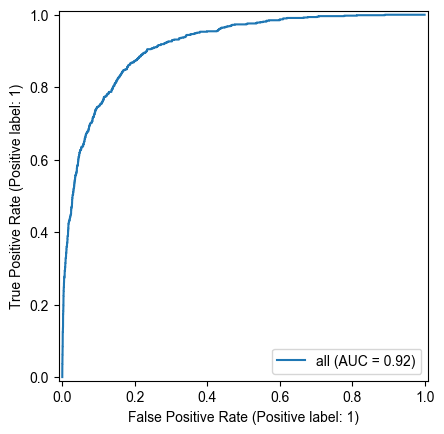

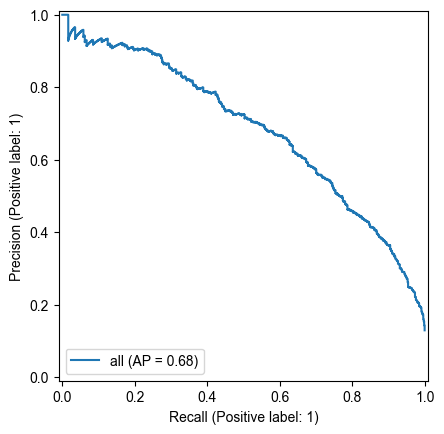

In [52]:
fig,ax = plt.subplots()
fig2,ax2 = plt.subplots()

datasets = ['all']

for data in datasets:
    ### Selecting the data:
    if data == 'all':
        # splitting the data:
        x_data = x_test
    else:
        x_data = x_test.loc[:,data]
    
    ### Selecting the model:
    model = tool_models[data]

    # Get the probabilities:
    probabilities = model.predict_proba(x_data)

    # Threshold for calling an RNA-binding amino acid:
    fixed_threshold = 0.80
    y_pred = np.where(probabilities[:, 1] >= fixed_threshold, 1, 0)
    
    # Evaluate the XGBoost model:
    print(f"Data used:\t{data}\n")
    print(classification_report(y_test, y_pred))
    
    # Calculate Matthews correlation coefficient:
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"MCC:\t{mcc}")
        
    RocCurveDisplay.from_estimator(model,
                                   x_data,
                                   y_test,
                                   name = data,
                                   ax=ax)

    PrecisionRecallDisplay.from_estimator(model,
                                          x_data,
                                          y_test,
                                          name = data,
                                          ax=ax2)

fig.savefig(f"{out_dir}/ROC_curve_analysis_all_features_pocket_second_model.pdf",dpi=400)
fig2.savefig(f"{out_dir}/Precision_Recall_analyses_all_features_pocket_second_model.pdf",dpi=400)

### Plotting postiive likelihood ratios against sensitivities: 

### Getting the best classifier for the restults from the individual tools:

A Positive Likelihood Ratio (PLR) is a statistical measure used in medical diagnostics and binary classification tasks to assess the ability of a test or model to correctly identify positive cases (true positives) relative to false positives. It quantifies how much more likely a positive test result or prediction is in individuals with the condition or class of interest compared to those without it. In other words, it measures the strength of the relationship between a positive result and the presence of the condition or class.

The formula for the Positive Likelihood Ratio (PLR) is:

P
L
R
=
Sensitivity
1 - Specificity
PLR= 
1 - Specificity
Sensitivity
​	
 
Where:

Sensitivity (True Positive Rate) is the proportion of true positive cases correctly identified by the test or model.
Specificity (True Negative Rate) is the proportion of true negative cases correctly identified by the test or model.
The PLR can take on values greater than 1.0. The larger the PLR, the more powerful the test or model is at correctly identifying positive cases while minimizing false positives. A PLR of 1.0 indicates that the test or model does not discriminate between positive and negative cases, while a higher PLR indicates better discrimination.

Interpretation of PLR values:

PLR < 1.0: A positive result is less likely in individuals with the condition, suggesting poor diagnostic or classification performance.
PLR = 1.0: A positive result is equally likely in individuals with and without the condition, indicating no discrimination.
PLR > 1.0: A positive result is more likely in individuals with the condition, indicating better discrimination, with higher values indicating stronger discrimination.
In summary, the Positive Likelihood Ratio helps assess the diagnostic or classification performance of a test or model by quantifying how much more likely a positive result is in individuals with the condition or class of interest compared to those without it.

In [53]:
def positiveLikelihoodRatios(y_test, y_pred_prob):
    sensitivities = []
    plrs = []
    thresholds = np.linspace(0.1, 0.99, 101)  # Create 101 equally spaced thresholds

    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        # Check for division by zero in sensitivity and specificity calculations
        if conf_matrix[1, 0] + conf_matrix[1, 1] == 0:
            sensitivity = 0.0
        else:
            sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
        
        if conf_matrix[0, 0] + conf_matrix[0, 1] == 0:
            specificity = 0.0
        else:
            specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        
        epsilon = 1e-10  # Small offset to prevent division by very small numbers
        
        if specificity == 0:
            plr = np.inf
        else:
            plr = sensitivity / (1 - specificity + epsilon)
        
        sensitivities.append(sensitivity)
        plrs.append(plr)
        
    return plrs, sensitivities


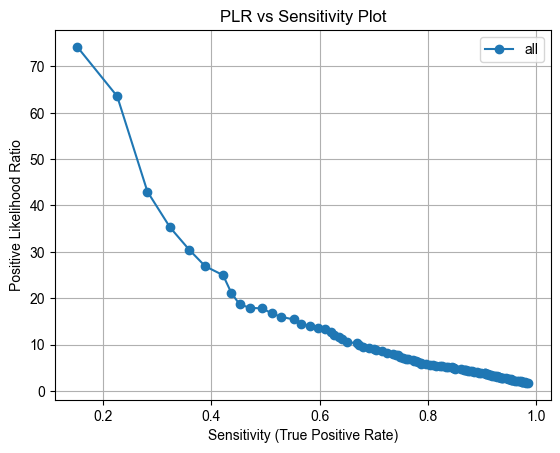

In [54]:
fig3,ax3 = plt.subplots()
datasets = ['all']

for data in datasets:
    ### Selecting the data:
    if data == 'all':
        # splitting the data:
        x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
    else:
        x_train, x_test, y_train, y_test = train_test_split(x.loc[:,data],y,test_size=0.20,random_state=42,stratify=y)

    ### Selecting the model:
    model = tool_models[data]
    
    # Get the probabilities:
    probabilities = model.predict_proba(x_test)[:,1]
    y_test = np.squeeze(y_test)
    plrs,sensitivities = positiveLikelihoodRatios(y_test,probabilities)

    ax3.plot(sensitivities, plrs, marker='o',label=data)
    ax3.set_xlabel('Sensitivity (True Positive Rate)')
    ax3.set_ylabel('Positive Likelihood Ratio')
    ax3.set_title('PLR vs Sensitivity Plot')
    ax3.legend()
    plt.grid(True)
    #fig3.savefig(f"{out_dir}/PLR_vs_sensitivity_plot_pocket.pdf", dpi=400)

Text(0.5, 1.0, 'Feature Importance Analysis')

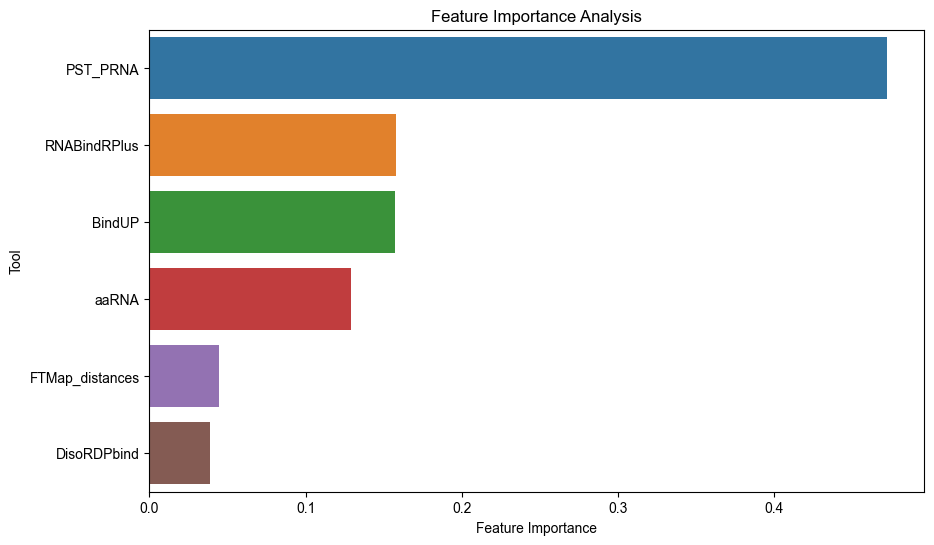

In [55]:
# Access feature importances
feature_importances = tool_models['all'].feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Tool': columns_with_prediction_results, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Tool', data=importance_df)
plt.xlabel('Feature Importance')
plt.ylabel('Tool')
plt.title('Feature Importance Analysis')
#plt.savefig(f'{out_dir}/Feature_Importance_Analysis_pocket_data.pdf',dpi=400)

In [56]:
normalized_importances = feature_importances / sum(feature_importances)

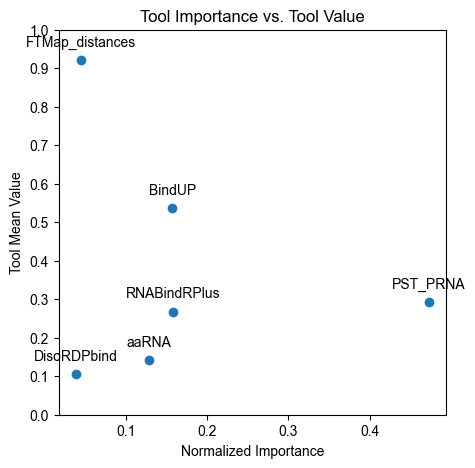

In [57]:
# Calculate the mean values for each tool
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
# undersampling the majority class:
x_train_undersampled,y_train_undersampled = undersampleMajorityClass(x_train,y_train)

tool_means = np.mean(x_train_undersampled, axis=0)  # Assuming x_train contains data for each tool

# Create a scatter plot
plt.figure(figsize=(5,5))
plt.scatter(normalized_importances, tool_means, marker='o')
plt.xlabel('Normalized Importance')
plt.yticks(np.arange(0,1.1,0.1))
plt.ylabel('Tool Mean Value')
plt.title('Tool Importance vs. Tool Value')

# Annotate the points with tool names
for i, tool_name in enumerate(columns_with_prediction_results):
    plt.annotate(tool_name, (normalized_importances[i], tool_means[i]),
                 textcoords="offset points", xytext=(0,10), ha='center')

#plt.savefig(f'{out_dir}/Tool_Importance_vs_Tool_value_pocket_data.pdf',dpi=400)

When you observe that a tool with low importance has a high mean value, it can be quite intriguing and requires careful interpretation. This situation might indicate a few different scenarios, and your domain knowledge will play a significant role in making sense of it. Here are a couple of possible explanations:

1) Feature Redundancy or Collinearity: The tool with the low importance but high mean value might be highly correlated with other tools that are already considered important. In this case, the predictive power of that tool might be redundant due to its similarity with other informative tools. XGBoost's feature selection process might favor other correlated features, leading to lower importance for this tool. However, it still has a high mean value, suggesting that it carries relevant information, but that information might be partially captured by other tools.
2) Non-Linear Relationships: XGBoost and other tree-based models capture non-linear relationships effectively. It's possible that the tool with low importance and high mean value has a non-linear relationship with the target variable that the model is not fully capturing. The model might be assigning more importance to other features that interact with the target in different ways.
3) Noise or Outliers: It's also possible that the high mean value for that tool could be due to noise or outliers in the data. Such values might not be representative of the true relationship between the tool and the target variable.
4) Domain Knowledge: In the context of your specific biological problem, this tool might have a unique mechanism or interaction that isn't captured well by the model. This could lead to the tool having a high mean value despite its low importance in the model.


### Looking at the correlation matrices:

In [58]:
corr_matrix = x.corr()

In [59]:
corr_matrix

aaRNA  PST_PRNA    BindUP  FTMap_distances  RNABindRPlus  \
aaRNA            1.000000  0.486549  0.295619        -0.023482      0.473285   
PST_PRNA         0.486549  1.000000  0.365749         0.062062      0.553754   
BindUP           0.295619  0.365749  1.000000         0.090211      0.320955   
FTMap_distances -0.023482  0.062062  0.090211         1.000000      0.040170   
RNABindRPlus     0.473285  0.553754  0.320955         0.040170      1.000000   
DisoRDPbind      0.294902  0.189104  0.168110         0.021051      0.171542   

                 DisoRDPbind  
aaRNA               0.294902  
PST_PRNA            0.189104  
BindUP              0.168110  
FTMap_distances     0.021051  
RNABindRPlus        0.171542  
DisoRDPbind         1.000000

### Now testing for overfitting:

In [60]:
# Lists to store training and validation errors

model = tool_models['all']

# Splitting the data:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
# undersampling the majority class:
x_train_undersampled,y_train_undersampled = undersampleMajorityClass(x_train,y_train)
# Fitting the model:
model.fit(x_train_undersampled,y_train_undersampled,verbose=False)

# Get the training and validation error for this iteration
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

sys.stdout.write(f"Train mean squared error:\t{train_error}\nTest mean squared error:\t{test_error}\n")

Train mean squared error:	0.12819044502617802
Test mean squared error:	0.16230366492146597


91

### The fact that the validation and training errors are quite close would suggest that my model is not overfitting.

### Let's also assess overfitting by making learning curves:

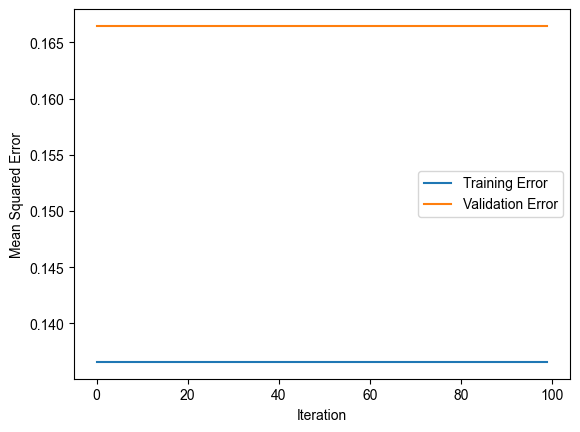

In [61]:
model = tool_models['all']

# Lists to store training and validation errors
train_errors = []
valid_errors = []

# Train the model and collect errors at each iteration
for i in range(100):  # Change the number of iterations as needed
    # Splitting the data:
    x_train_learn, x_test_learn, y_train_learn, y_test_learn = train_test_split(x_train,y_train,test_size=0.20,random_state=42,stratify=y_train)
    x_train_undersampled,y_train_undersampled = undersampleMajorityClass(x_train_learn,y_train_learn)
    # Fitting the model:
    model.fit(x_train_undersampled,y_train_undersampled,verbose=False)
    
    # Get the training and validation error for this iteration
    y_train_pred = model.predict(x_train_learn)
    y_test_pred = model.predict(x_test_learn)
    
    train_error = mean_squared_error(y_train_learn, y_train_pred)
    valid_error = mean_squared_error(y_test_learn, y_test_pred)
    
    train_errors.append(train_error)
    valid_errors.append(valid_error)

# Plot learning curves
plt.plot(train_errors, label='Training Error')
plt.plot(valid_errors, label='Validation Error')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.legend()
#plt.savefig(f'{out_dir}/Training_errors_plot.pdf',dpi=400)
plt.show()

### Learning curves can give flat lines for various reasons, and interpreting these flat lines requires considering the specific context of your machine learning problem. Here are some common reasons why learning curves might appear flat:

Sufficiently Trained Model: If the learning curves show that both the training and validation errors have stabilized at relatively low values and are not changing significantly with more data or iterations, it may indicate that your model has been trained sufficiently. In this case, you've likely reached the best performance achievable with your current model and dataset.

Data Size: If you have a large dataset, learning curves may stabilize quickly because the model has already seen enough diverse examples to learn from. In such cases, collecting more data may not significantly affect model performance.

Simple Model: If your model is relatively simple and has low capacity (e.g., shallow decision trees or linear models), it may converge quickly and produce flat learning curves.

Hyperparameter Tuning: If you've carefully tuned your hyperparameters and regularization techniques, you might achieve stable and flat learning curves earlier in the training process.

Data Quality: If your dataset is of high quality, well-preprocessed, and doesn't contain much noise or outliers, your model may converge more quickly, leading to flat learning curves.

Early Stopping: If you're using techniques like early stopping during training, the learning curves may appear flat because training stops when further iterations do not significantly improve the model's performance on the validation set.

Model Capacity: If your model has a high capacity and is prone to overfitting, it may exhibit a gap between training and validation errors initially. However, if you've applied proper regularization techniques, this gap can narrow, leading to flat learning curves once overfitting is controlled.

Data Imbalance: In classification tasks with imbalanced classes, you might observe flat learning curves because the model quickly learns to classify the majority class correctly, while the minority class may remain challenging to predict accurately.

### Adding the prediction results for the test data:

In [73]:
# Load the XGBoost model. This has been trained on all the predictors.
model = xgb.XGBClassifier()
model.load_model("xgboost_models/all_pocket_model_reduced_training.xgb")

### Making the predictions on the data.
Only probabilities will be reported the user can then set an arbitrary threshold (0.8 is recommended) for calling whether an amino acid binds RNA or not.

In [74]:
new_test_data = selected_data.loc[selected_data['Distance_to_PLIP'] >= 0] 

In [75]:
new_test_data.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
921    921  I3LGP4  I3LGP4_merged              16          E  0.044966   
922    922  I3LGP4  I3LGP4_merged              17          I  0.018268   
923    923  I3LGP4  I3LGP4_merged              18          T  0.016561   
924    924  I3LGP4  I3LGP4_merged              19          P  0.006524   
925    925  I3LGP4  I3LGP4_merged              20          D  0.045267   

     PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
921       0.0    0.0              NaN          0.01         0.23    0.0   
922       0.0    0.0              NaN          0.01         0.27    0.0   
923       0.0    0.0              NaN          0.01         0.24    0.0   
924       0.0    0.0              NaN          0.01         0.18    0.0   
925       0.0    0.0              NaN          0.01         0.17    0.0   

     Distance_to_RNA  PLIP  Distance_to_PLIP  
921                0   0.0         37.012328  
922                0   0.0         36.420605  
923                0   0.0         32.660885  
924                0   0.0         35.548293  
925                0   0.0         34.488847

In [76]:
columns_with_prediction_results = ['aaRNA','PST_PRNA','BindUP','FTMap_distances','RNABindRPlus','DisoRDPbind']
x = new_test_data.loc[:,columns_with_prediction_results]
x = convertToNumeric(x,columns_with_prediction_results)
x.replace([np.inf,-np.inf], np.nan, inplace=True)
x = x.dropna()
y = new_test_data.loc[x.index,ground_truth]

In [77]:
x.head()

aaRNA  PST_PRNA  BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind
2068  0.154271      0.07     0.0         0.693960          0.01         0.05
2069  0.419050      0.02     0.0         0.705874          0.54         0.04
2070  0.070963      0.05     0.0         0.717513          0.01         0.04
2071  0.171836      0.35     0.0         0.751050          0.01         0.05
2072  0.175951      0.44     0.0         0.752496          0.01         0.03

In [78]:
predictions = model.predict_proba(x)[:,1]

In [79]:
new_test_data = new_test_data.loc[x.index]

In [80]:
len(new_test_data.index)

21702

In [81]:
new_test_data['predictions'] = predictions*100

In [82]:
new_test_data.head()

index      ID         pdb_id  residue_number amino_acid     aaRNA  \
2068   2068  O14802  O14802_merged               2          V  0.154271   
2069   2069  O14802  O14802_merged               3          K   0.41905   
2070   2070  O14802  O14802_merged               4          E  0.070963   
2071   2071  O14802  O14802_merged               5          Q  0.171836   
2072   2072  O14802  O14802_merged               6          F  0.175951   

      PST_PRNA BindUP  FTMap_distances  RNABindRPlus  DisoRDPbind  HydRa  \
2068      0.07    0.0         0.693960          0.01         0.05    0.0   
2069      0.02    0.0         0.705874          0.54         0.04    0.0   
2070      0.05    0.0         0.717513          0.01         0.04    0.0   
2071      0.35    0.0         0.751050          0.01         0.05    0.0   
2072      0.44    0.0         0.752496          0.01         0.03    0.0   

      Distance_to_RNA  PLIP  Distance_to_PLIP  predictions  
2068                0   0.0         59.714149    23.915846  
2069                0   0.0         57.670548    71.018280  
2070                0   0.0         52.657547    22.022648  
2071                0   0.0         52.053734    52.844440  
2072                0   0.0         49.351630    60.379307

In [83]:
new_test_data.to_csv(f"{out_dir}/Test_data_with_predictions_for_performance_analysis.txt",sep="\t")